## Assignment 2, Natural Language Processing, Group 14

# In this notebook, further experiments with FLSA-W model are conducted. The best model from the first iterations kept as a reference point.

## Filter corpus

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
import re
import random
random.seed(45)

# Load and filter the data
news_df = pd.read_csv('us_equities_news_dataset.csv')
news_df = news_df.drop(columns=['article_id', 'url', 'category', 'release_date', 'provider'])
news_df = news_df.dropna(subset=['content'])
news_df['content'] = news_df['content'].astype(str)


# Filter for articles mentioning 'Nvidia' or 'NVDA' in the ticker, title, or content
pattern_nvidia = r'\b(?:Nvidia|NVDA)\b'
nvidia_mentioned_articles = news_df[
    (news_df['ticker'] == 'NVDA') | 
    news_df['title'].str.contains(pattern_nvidia, case=False, na=False) |
    news_df['content'].str.contains(pattern_nvidia, case=False, na=False)
]

# Save and reload filtered articles to avoid duplicate content
filtered_corpus = nvidia_mentioned_articles.copy()
filtered_corpus.to_csv('filtered_corpus.csv', index=False)

print('Filtered corpus dimensions:', filtered_corpus.shape)

Filtered corpus dimensions: (3459, 4)


## Clean and tokenize filtered corpus

In [2]:
news_df = pd.read_csv('filtered_corpus.csv')

# Set up stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess and tokenize text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove 1-letter words and stopwords
    tokens = [token for token in tokens if len(token) > 1 and token not in stop_words]
    return tokens

# Apply the function to the content column and create a new 'tokens' column
news_df['tokens'] = news_df['content'].apply(preprocess_text)

# Remove duplicates based on the 'tokens' column
df = news_df.drop_duplicates(subset=['tokens'])
print('Filtered corpus dimensions:', df.shape)
print(df[['content', 'tokens']].head(10))


Filtered corpus dimensions: (3306, 5)
                                             content  \
0  ECB Effects\nThe move in the euro was huge  fa...   
1  6 Stocks To Watch  March 6 Trading Session\nSt...   
2  Investing com   A rout in Apple and Facebook  ...   
3  For Immediate ReleaseChicago  IL   January 13 ...   
4  With 4 500 companies bringing their innovation...   
5  With 4 500 companies bringing their innovation...   
6  When trading opened in 2019  investors were ju...   
7  Excitement is building up for the 2020 Summer ...   
8  For Immediate ReleaseChicago  IL   December 3 ...   
9  For Immediate ReleaseChicago  IL   November 26...   

                                              tokens  
0  [ecb, effects, move, euro, huge, falling, pips...  
1  [stocks, watch, march, trading, session, stock...  
2  [investing, com, rout, apple, facebook, nasdaq...  
3  [immediate, releasechicago, il, january, zacks...  
4  [companies, bringing, innovations, ces, jan, g...  
5  [companies, 

In [3]:
# Function to convert the tokenized column to a list of lists (flatten list)
def make_list_of_lists(data_frame, column_name):
    data = data_frame[column_name].tolist()
    return data

# Create the list of lists for modeling
data = make_list_of_lists(df, 'tokens')
print('Number of documents in the list of lists:', len(data))

Number of documents in the list of lists: 3306


## top-n% bottom-n% removal

In [4]:
from collections import Counter

def remove_n_percent(processed_text, n=0):
    if n > 0:
        # Flatten the list of lists to count word frequencies
        word_freq = Counter([word for doc in processed_text for word in doc])
        # Get the top n% most frequent words
        top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
        # Get the bottom n% least frequent words
        bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
        # Filter the data to remove these words
        processed_text = [[word for word in doc if word not in top_n and word not in bottom_n] for doc in processed_text]
        processed_text = [doc for doc in processed_text if len(doc) > 0]
    return processed_text

# Experimentation

# Best model with top-n% bottom-n% removal

In [12]:
from FuzzyTM import FLSA_W
# Parameters
flsaw_data = remove_n_percent(data, 20)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0201*"experiment" + 0.0158*"worlds" + 0.013*"deficits" + 0.0127*"accessed" + 0.0106*"unfolding" + 0.0087*"tantrum" + 0.0087*"blunder" + 0.0082*"quebec" + 0.0082*"sabia" + 0.0082*"cacophony"'), (1, '0.0107*"fines" + 0.0102*"omnichannel" + 0.0098*"convincing" + 0.0091*"pen" + 0.0089*"empirical" + 0.0088*"blur" + 0.0085*"believer" + 0.0085*"enters" + 0.008*"radically" + 0.008*"piper"'), (2, '0.0416*"regularly" + 0.0353*"programmed" + 0.0329*"bag" + 0.032*"colleague" + 0.0297*"evolutionary" + 0.0293*"hacked" + 0.0267*"thaler" + 0.0253*"consist" + 0.0225*"miniaturization" + 0.0202*"modification"'), (3, '0.0573*"originated" + 0.0445*"infections" + 0.0433*"lethal" + 0.0433*"pigs" + 0.0429*"kasparov" + 0.0429*"garry" + 0.0424*"impoverished" + 0.0421*"antiviral" + 0.042*"references" + 0.0418*"pneumonia"'), (4, '0.0024*"unfold" + 0.0023*"judicious" + 0.0023*"jaw" + 0.0023*"basics" + 0.0022*"verified" + 0.0021*"honeywell" + 0.002*"strides" + 0.002*"quantities" + 0.002*"congestion" + 0.002

Removing the top and bottom 20% of the most frequent words seems to have improved coherence without significantly affecting diversity. This suggests that the common and rare words removed in this step were likely not contributing much to topic quality. However, by relying solely on raw frequency, we may have removed important words from the corpus. 

To address this, we can use a document frequency threshold as part of the TF-IDF calculation, removing words based on the proportion of documents they appear in rather than just their raw frequency. This approach takes into account how widely or narrowly distributed a word is across the corpus. 

Detecting bigrams and trigrams and applying TF-IDF-based filtering (using max_df and min_df) is can be a relatively safer approach. This method identifies word pairs and triplets that convey significant meaning, capturing important multi-word phrases like “stock market” or “price increase” that single-word analysis might overlook. Next, TF-IDF filtering adapts to the actual distribution of words across documents, effectively removing overly common or extremely rare terms based on their document frequency. This may provide a more targeted and context-aware way to clean data compared to the more arbitrary removal of a fixed top and bottom percentage, which risks excluding contextually important words or retaining irrelevant ones. Further experiments on FLSA-W model are presented in a separate jupyter notebook named "Experiments with FLSA-W".

## Lemmatization Experiment

In [13]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unsure

# Function to apply lemmatization with POS tagging to a list of lists
def lemmatize_list_of_lists(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_data = []

    for doc in data:
        pos_tags = pos_tag(doc)  # Apply POS tagging to each document
        lemmatized_doc = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
        lemmatized_data.append(lemmatized_doc)  # Append the lemmatized document to the list

    return lemmatized_data

data_lem = lemmatize_list_of_lists(data)

In [14]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 20)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.5242*"survival" + 0.1176*"approximate" + 0.0318*"adult" + 0.023*"specie" + 0.0126*"born" + 0.0126*"gould" + 0.0118*"god" + 0.0108*"feynman" + 0.0104*"conscious" + 0.0087*"harvard"'), (1, '0.0047*"surroundings" + 0.0043*"crumble" + 0.0042*"supportive" + 0.0041*"harvest" + 0.0041*"mechanical" + 0.004*"harbinger" + 0.0038*"toolkit" + 0.0037*"counterpoint" + 0.0037*"rejoice" + 0.0035*"elderly"'), (2, '0.0117*"flipgrid" + 0.0117*"hugger" + 0.0117*"congruence" + 0.0117*"trivia" + 0.0117*"explanatory" + 0.0117*"lowland" + 0.0117*"geology" + 0.0117*"sloman" + 0.0117*"coherence" + 0.0117*"unesco"'), (3, '0.0418*"happiness" + 0.0417*"vested" + 0.0417*"guaranteed" + 0.0414*"orbit" + 0.041*"astronaut" + 0.0399*"ritual" + 0.0395*"kingdoms" + 0.0389*"livestock" + 0.0388*"npr" + 0.0387*"narrate"'), (4, '0.0097*"reed" + 0.0093*"symbol" + 0.0091*"protectionism" + 0.0087*"offense" + 0.0084*"coo" + 0.0083*"disturb" + 0.0074*"expression" + 0.0073*"workaround" + 0.0072*"updating" + 0.007*"resultant

## Lemmatization did not improve the coherence score.

# N-gram detection and TF-IDF base filtering

# We can include bigrams and trigrams to the vocabulary and filter out by document frequency.

In [15]:
# Gensim
import gensim

# Create Bigram and Trigram Models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data], threshold=100)

# Convert the bigram and trigram models to Phrasers for efficiency
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Apply the Bigram/Trigram Models
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_bigram = make_bigrams(data)
data_trigram = make_trigrams(data_bigram)


In [16]:
# Print the (bigrams/trigrams) in the first 10 documents
print("Bigrams/Trigrams with underscores in the first 10 documents:")
for i, doc in enumerate(data_trigram[:3]):
    words_with_underscores = [word for word in doc if '_' in word]
    print(f"Document {i+1}: {words_with_underscores}")

Bigrams/Trigrams with underscores in the first 10 documents:
Document 1: ['worth_noting', 'couple_weeks', 'russell_iwm_russell', 'head_shoulders', 'filling_gap', 'jd_jd', 'original_post']
Document 2: ['manufacturing_pmi', 'roku_roku', 'original_post']
Document 3: ['investing_com', 'dow_jones_industrial', 'wall_street_journal', 'wall_street_journal', 'ceo_mark_zuckerberg', 'social_media_giant', 'played_role', 'oil_prices', 'european_union', 'sanctions_iran', 'production_cuts', 'defensive_sectors', 'positive_territory', 'vice_president', 'chinese_goods', 'meeting_president_donald', 'chinese_president_xi', 'united_states', 'chinese_goods', 'national_association', 'home_builders', 'wells_fargo', 'citron_research', 'andrew_left', 'upbeat_assessment', 'gainers_losers', 'helmerich_payne', 'molson_coors', 'gainers_session', 'salesforce_com', 'among_worst_performers']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_tfidf_filtering(data_ngrams, min_df=0.05, max_df=0.8):
    """
    Apply TF-IDF filtering to tokenized data containing bigrams and trigrams and return filtered data and removed words.

    Parameters:
    - data_ngrams: list of lists, each containing bigram and/or trigram tokens of a document.
    - min_df: float, minimum document frequency threshold for TF-IDF filtering.
    - max_df: float, maximum document frequency threshold for TF-IDF filtering.

    Returns:
    - data_tf_ngrams: list of lists, filtered bigram and trigram tokenized data.
    - removed_words: set of words that were removed by TF-IDF filtering.
    """
    # Convert the n-grams to a DataFrame if not already in one
    df_ngrams = pd.DataFrame({'ngram_tokens': data_ngrams})

    # Convert the n-gram tokens back to text format for TF-IDF processing
    df_ngrams['ngram_text'] = df_ngrams['ngram_tokens'].apply(lambda x: ' '.join(x))

    # Apply TF-IDF vectorization to the n-gram text
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_ngrams['ngram_text'])

    # Get the feature names (words or n-grams) that meet the TF-IDF thresholds
    tfidf_vocab = set(tfidf_vectorizer.get_feature_names_out())

    # Filter out tokens in each document that do not meet the TF-IDF criteria
    df_ngrams['filtered_ngram_tokens'] = df_ngrams['ngram_tokens'].apply(
        lambda text: [word for word in text if word in tfidf_vocab]
    )

    # Convert the final filtered tokens to a list of lists for topic modeling
    data_tf_ngrams = df_ngrams['filtered_ngram_tokens'].tolist()
    data_tf_ngrams = [doc for doc in data_tf_ngrams if len(doc) > 0]  # Remove empty documents

    return data_tf_ngrams

data_tf_bigram = apply_tfidf_filtering(data_bigram, min_df=0.05, max_df=0.8)
data_tf_trigram = apply_tfidf_filtering(data_trigram, min_df=0.05, max_df=0.8)


## Training the alternative models and comparing elbow plots

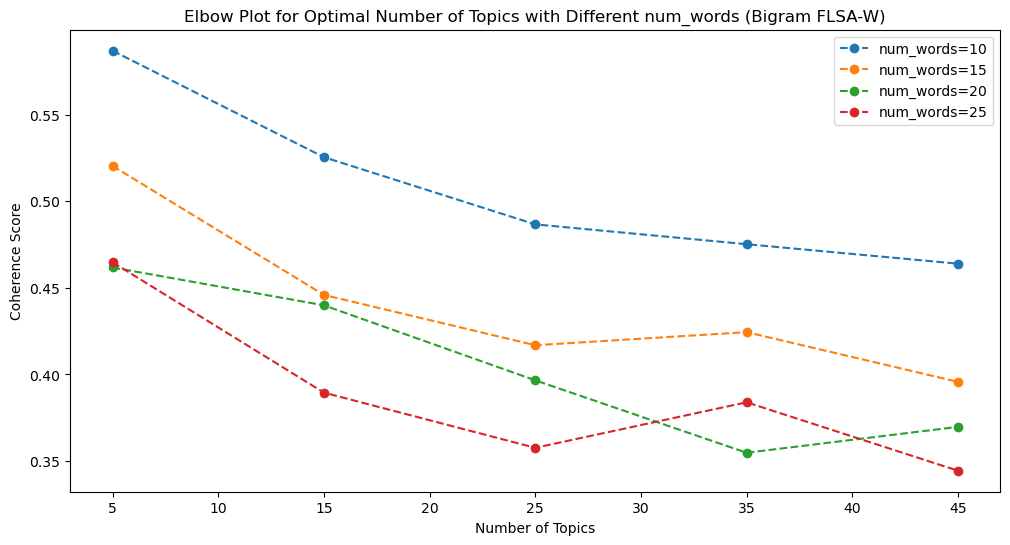

In [18]:
import matplotlib.pyplot as plt

# Parameters
# Define the range for number of topics and number of words to test
flsaw_data = data_tf_bigram
topic_numbers = range(5, 51, 10)
num_words_list = [10, 15, 20, 25]

# Create a dictionary to store coherence scores for different num_words
coherence_scores_dict = {}

# Loop over each num_words value
for num_words in num_words_list:
    coherence_scores = []
    for num_topics in topic_numbers:
        flsaW = FLSA_W(
            input_file=flsaw_data,  # Preprocessed data
            num_topics=num_topics,
            num_words=num_words
        )
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()  # Calculate coherence
        coherence_scores.append(coherence_score)
    
    # Store coherence scores for the current num_words
    coherence_scores_dict[num_words] = coherence_scores

# Plotting the Elbow Plot with multiple lines
plt.figure(figsize=(12, 6))
for num_words, scores in coherence_scores_dict.items():
    plt.plot(topic_numbers, scores, marker='o', linestyle='--', label=f'num_words={num_words}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics with Different num_words (Bigram FLSA-W)')
plt.legend()
plt.show()

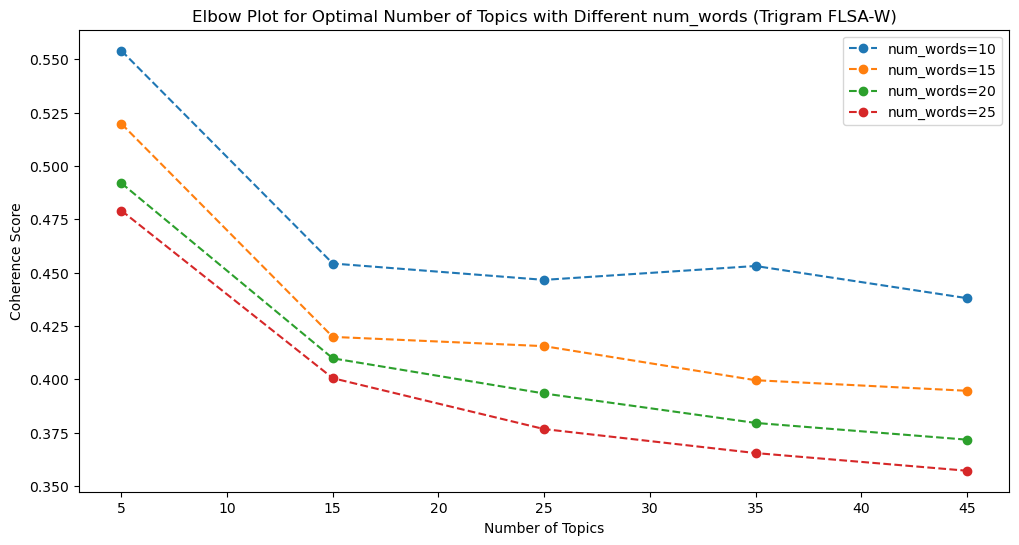

In [19]:
# Parameters
# Define the range for number of topics and number of words to test
flsaw_data = data_tf_trigram
topic_numbers = range(5, 51, 10)
num_words_list = [10, 15, 20, 25]

# Create a dictionary to store coherence scores for different num_words
coherence_scores_dict = {}

# Loop over each num_words value
for num_words in num_words_list:
    coherence_scores = []
    for num_topics in topic_numbers:
        flsaW = FLSA_W(
            input_file=flsaw_data,  # Preprocessed data
            num_topics=num_topics,
            num_words=num_words
        )
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()  # Calculate coherence
        coherence_scores.append(coherence_score)
    
    # Store coherence scores for the current num_words
    coherence_scores_dict[num_words] = coherence_scores

# Plotting the Elbow Plot with multiple lines
plt.figure(figsize=(12, 6))
for num_words, scores in coherence_scores_dict.items():
    plt.plot(topic_numbers, scores, marker='o', linestyle='--', label=f'num_words={num_words}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics with Different num_words (Trigram FLSA-W)')
plt.legend()
plt.show()

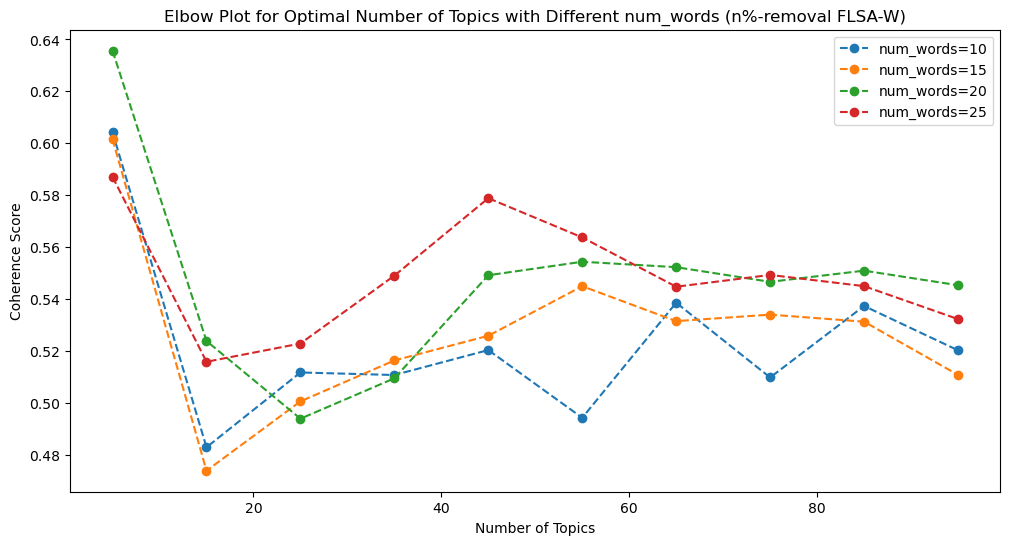

In [20]:
# Define the range for number of topics and number of words to test
topic_numbers = range(5, 101, 10)
num_words_list = [10, 15, 20, 25]
flsaw_data = remove_n_percent(data, 20)
# Create a dictionary to store coherence scores for different num_words
coherence_scores_dict = {}

# Loop over each num_words value
for num_words in num_words_list:
    coherence_scores = []
    for num_topics in topic_numbers:
        flsaW = FLSA_W(
            input_file=flsaw_data,  # Preprocessed data
            num_topics=num_topics,
            num_words=num_words
        )
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()  # Calculate coherence
        coherence_scores.append(coherence_score)
    
    # Store coherence scores for the current num_words
    coherence_scores_dict[num_words] = coherence_scores

# Plotting the Elbow Plot with multiple lines
plt.figure(figsize=(12, 6))
for num_words, scores in coherence_scores_dict.items():
    plt.plot(topic_numbers, scores, marker='o', linestyle='--', label=f'num_words={num_words}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics with Different num_words (n%-removal FLSA-W)')
plt.legend()
plt.show()

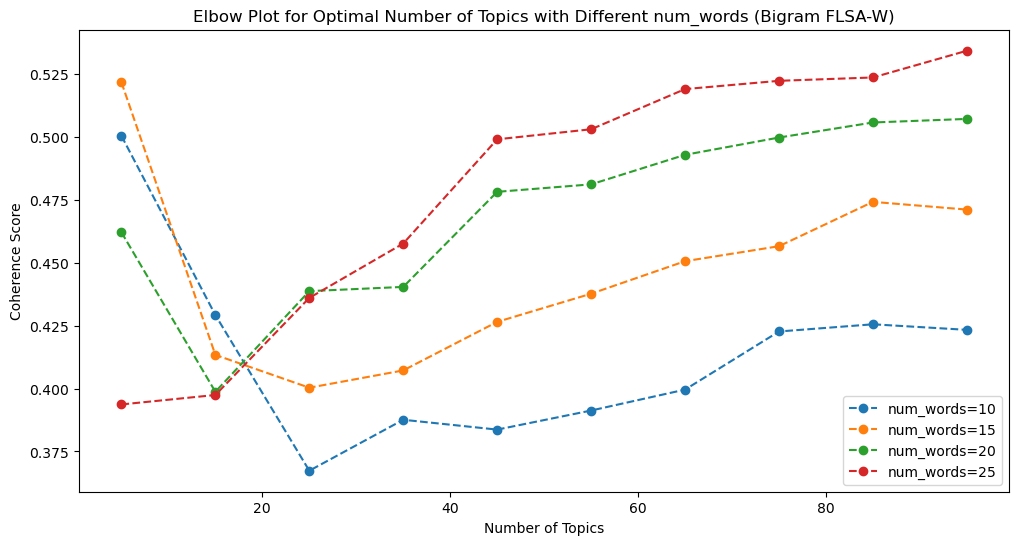

In [21]:
# Define the range for number of topics and number of words to test
flsaw_data = data_trigram
topic_numbers = range(5, 101, 10)
num_words_list = [10, 15, 20, 25]

# Create a dictionary to store coherence scores for different num_words
coherence_scores_dict = {}

# Loop over each num_words value
for num_words in num_words_list:
    coherence_scores = []
    for num_topics in topic_numbers:
        flsaW = FLSA_W(
            input_file=flsaw_data,  # Preprocessed data
            num_topics=num_topics,
            num_words=num_words
        )
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()  # Calculate coherence
        coherence_scores.append(coherence_score)
    
    # Store coherence scores for the current num_words
    coherence_scores_dict[num_words] = coherence_scores

# Plotting the Elbow Plot with multiple lines
plt.figure(figsize=(12, 6))
for num_words, scores in coherence_scores_dict.items():
    plt.plot(topic_numbers, scores, marker='o', linestyle='--', label=f'num_words={num_words}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics with Different num_words (Bigram FLSA-W)')
plt.legend()
plt.show()

## Conclusion: The comparison of the three methods indicates that n-gram and TF-IDF filtering yields the best coherence scores with a low number of words per topic (num_words ≤ 10) and a lower number of topics per document (num_topics ≤ 15). On the other hand, 20% top and 20% bottom removal based on frequency performs better with a high number of words per topic (num_words ≥ 20) and a moderate to high number of topics per document (num_topics ≥ 45), albeit with a higher risk of excluding contextually important words, which could result in losing valuable information while maintaining more nuanced topics. Capturing common phrases with bigrams and trigrams gives best results with around 40-50 topics and 20-25 numbers. It can be an alternative approach to tf-df filtering if higher number of topics are preferred.

## Examples of optimal cases for each model are shown below to qualitatively assess the topics.

In [22]:
flsaw_data = data_tf_bigram
num_topics=10
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0596*"hold" + 0.0508*"buy" + 0.0471*"sell" + 0.0442*"current" + 0.0441*"performance" + 0.0439*"stocks" + 0.0417*"past" + 0.0413*"information" + 0.037*"research" + 0.0363*"sectors"'), (1, '0.0093*"corporation" + 0.0081*"believe" + 0.0075*"group" + 0.0073*"boost" + 0.0073*"increasing" + 0.0072*"expects" + 0.0068*"following" + 0.0067*"fourth" + 0.0066*"drive" + 0.0064*"compared"'), (2, '0.0056*"advanced_micro" + 0.0053*"jumped" + 0.0052*"graphics" + 0.0052*"qcom" + 0.005*"chipmaker" + 0.0049*"released" + 0.0048*"holding" + 0.0047*"hardware" + 0.0047*"volume" + 0.0046*"provided"'), (3, '0.0068*"tuesday" + 0.0065*"fell" + 0.006*"chinese" + 0.006*"led" + 0.0058*"followed" + 0.0057*"weeks" + 0.0057*"highest" + 0.0056*"drop" + 0.0055*"pressure" + 0.0055*"ended"'), (4, '0.0117*"aapl" + 0.0109*"according" + 0.0107*"index" + 0.0105*"gains" + 0.0104*"focus" + 0.0099*"trade" + 0.0098*"consumer" + 0.0097*"economic" + 0.0096*"lower" + 0.0094*"china"'), (5, '0.0068*"returned" + 0.0066*"united_

In [23]:
# Parameters
flsaw_data = data_tf_trigram
num_topics=10
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0102*"corp" + 0.0093*"inc" + 0.0086*"investments" + 0.0083*"range" + 0.0079*"near_term" + 0.0078*"expanding" + 0.0078*"surge" + 0.0077*"cloud_computing" + 0.0074*"approximately" + 0.0074*"likes"'), (1, '0.0142*"notably" + 0.0135*"surged" + 0.012*"additionally" + 0.0118*"respectively" + 0.0117*"beat" + 0.0112*"computing" + 0.0112*"value" + 0.0112*"moreover" + 0.011*"com" + 0.011*"date"'), (2, '0.0132*"average" + 0.0127*"likely" + 0.0126*"nearly" + 0.0118*"second" + 0.0113*"recently" + 0.0109*"rate" + 0.0108*"growing" + 0.0108*"line" + 0.0107*"increase" + 0.0106*"tech"'), (3, '0.0338*"subject_change_without_notice" + 0.0337*"views_opinions_expressed_may" + 0.0337*"management_activities_securities_returns" + 0.0337*"future_results_inherent" + 0.0337*"particular_investor_assumed_investments" + 0.0337*"advice_given_whether" + 0.0337*"constitutes_investment_legal_accounting" + 0.0337*"reflect_firm_whole" + 0.0337*"returns_actual_portfolios" + 0.0337*"visit_information_performance"'),

In [24]:
# Parameters
flsaw_data = remove_n_percent(data, 20)
num_topics=10
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0143*"animals" + 0.0137*"xanax" + 0.0123*"ancient" + 0.011*"prefrontal" + 0.011*"marketsi" + 0.011*"lectures" + 0.011*"majored" + 0.011*"ufc" + 0.011*"theamygdaloid" + 0.011*"mammalian"'), (1, '0.0191*"harvard" + 0.0134*"circuitry" + 0.0125*"severity" + 0.0118*"evidenced" + 0.0116*"searched" + 0.0116*"millennial" + 0.0114*"disorders" + 0.0113*"wit" + 0.0113*"homo" + 0.0111*"conducts"'), (2, '0.0099*"consequences" + 0.0098*"thrive" + 0.0094*"copy" + 0.0094*"enriched" + 0.0091*"shelves" + 0.009*"description" + 0.0087*"hunting" + 0.0086*"disastrous" + 0.0084*"brink" + 0.0084*"blank"'), (3, '0.0005*"presidents" + 0.0005*"tentative" + 0.0005*"lienert" + 0.0005*"moat" + 0.0005*"ironically" + 0.0005*"macbook" + 0.0005*"priority" + 0.0005*"grabbing" + 0.0005*"lure" + 0.0005*"burst"'), (4, '0.0013*"preferences" + 0.0013*"describing" + 0.0013*"gather" + 0.0013*"requested" + 0.0012*"pundits" + 0.0012*"irrational" + 0.0012*"fines" + 0.0012*"woman" + 0.0012*"coo" + 0.0012*"thomas"'), (5, '0

In [25]:
# Parameters
flsaw_data = remove_n_percent(data, 20)
num_topics=45
num_words=25

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.1061*"harari" + 0.0638*"ethical" + 0.0585*"gould" + 0.0585*"pursuit" + 0.0573*"myths" + 0.0502*"civilization" + 0.0228*"memories" + 0.0215*"biased" + 0.0191*"discoveries" + 0.0178*"isolating" + 0.0174*"naval" + 0.0154*"subjects" + 0.015*"studying" + 0.0147*"louisiana" + 0.013*"centre" + 0.0117*"comwelcome" + 0.0116*"tolerate" + 0.0115*"thompson" + 0.0111*"ayx" + 0.0103*"feldman" + 0.0102*"concludes" + 0.0097*"animal" + 0.0087*"harvard" + 0.0078*"attended" + 0.0078*"homo"'), (1, '0.0046*"lets" + 0.0045*"stealing" + 0.0044*"contractors" + 0.0044*"illinois" + 0.0042*"financially" + 0.0039*"concepts" + 0.0038*"internally" + 0.0034*"cry" + 0.0033*"brilliant" + 0.0033*"hinted" + 0.0033*"victims" + 0.0032*"railroad" + 0.0032*"layered" + 0.003*"tweak" + 0.0029*"magic" + 0.0029*"progressive" + 0.0029*"discounts" + 0.0029*"guardian" + 0.0028*"qualify" + 0.0028*"htc" + 0.0027*"placement" + 0.0027*"roller" + 0.0027*"loyal" + 0.0027*"laundry" + 0.0026*"propaganda"'), (2, '0.334*"xanax" + 0.

In [26]:
flsaw_data = data_trigram
num_topics=45
num_words=25

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0075*"highs" + 0.0068*"cars" + 0.0066*"firms" + 0.0066*"short" + 0.0064*"providing" + 0.0062*"offering" + 0.0061*"concern" + 0.0061*"equipment" + 0.006*"brand" + 0.006*"monday" + 0.0059*"online" + 0.0058*"fresh" + 0.0057*"components" + 0.0054*"difficult" + 0.0053*"advanced" + 0.0052*"efforts" + 0.0052*"inflation" + 0.0052*"offers" + 0.0051*"wait" + 0.0048*"value" + 0.0047*"october" + 0.0046*"allows" + 0.0045*"critical" + 0.0045*"bullish" + 0.0045*"true"'), (1, '0.0103*"gross_margin" + 0.0092*"pleased" + 0.0087*"consoles" + 0.0086*"intuitive_surgical" + 0.0081*"exiting" + 0.0072*"unmatched" + 0.0067*"mix" + 0.0067*"heavily_weighted" + 0.0067*"nevada" + 0.0067*"careers" + 0.0065*"guiding" + 0.0065*"console" + 0.0065*"credit_suisse" + 0.0063*"mitch_steves" + 0.0062*"gross_margins" + 0.0061*"server" + 0.006*"atlassian" + 0.006*"operator" + 0.0057*"ramps" + 0.0057*"xt" + 0.0056*"digging" + 0.0056*"visibility" + 0.0056*"mid_teens" + 0.0056*"notebook" + 0.0055*"ok"'), (2, '0.0117*"exp